In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

### Funcs

In [2]:
def plot_trajectory(position, orientation, scale, number_of_points_between_axis):
    plt.figure(figsize=(8, 5))
    plt.plot(position[:, 0], position[:, 1], label="Trajectory")
    plt.scatter(position[0, 0], position[0, 1], color="green", label="Start", s=50)
    plt.scatter(position[-1, 0], position[-1, 1], color="red", label="End", s=50)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.title('Trajectory in XY Plane')
    plt.grid()
    plt.show()

    # Plot the trajectory
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(position[:, 0], position[:, 1], position[:, 2], label="Trajectory")
    ax.scatter(position[0, 0], position[0, 1], position[0, 2], color="green", label="Start", s=50)
    ax.scatter(position[-1, 0], position[-1, 1], position[-1, 2], color="red", label="End", s=50)
    for i, pos, orient in zip(range(len(position)), position, orientation):
        if i%number_of_points_between_axis == 0:   
            plot_axes_by_Rot(ax, pos, orient, scale=scale)
    
    plot_axes_by_Rot(ax, position[-1], orientation[-1], scale=scale, legend=True)
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Z Position (m)')
    ax.legend()
    plt.show()
    
def trajectory(time, ang_vel, acceleration, scale=[1,1,1], number_of_points_between_axis=8):
    """Ang vel need to be in rad/s"""
    diff_t = np.diff(time)
    orientations = []
    orientations.append(R.from_euler('xyz', [np.pi, 0, 0])) # It starts facing down (seen from the gravity acceleration from the accelerometer)

    for ang_v, dt in zip(ang_vel[1:], diff_t):
        ang_p = ang_v * dt
        delta_rot = R.from_euler('xyz', ang_p)
        orientations.append(orientations[-1] * delta_rot)

    position = [[0]*3]
    gravity = np.array([0, 0, -9.81])  # Gravity
    velocity = [0,0,0]
    
    for current_orientation, acc, dt in zip(orientations[1:], acceleration[1:], diff_t):
        # Rotate to world frame
        acc_world = current_orientation.as_matrix() @ acc
        # Subtract gravity
        acc_world = acc_world - gravity

        velocity = velocity + acc_world * dt
        position.append(position[-1] + velocity * dt)
    
    plot_trajectory(np.array(position), orientations, scale, number_of_points_between_axis)   
    
def normalize_angle(angle):
    for i in range(len(angle[-1])):
        angle[-1][i] = (angle[-1][i] + 180) % 360 - 180
    return angle

def orientation_from_ang_vel(time, angular_vel):
    diff_t = np.diff(time)
    
    rotation = [R.from_euler('xyz', [-np.pi, 0, 0])]
    for ang_v, dt in zip(angular_vel[1:], diff_t):
        ang_p = ang_v * dt
        delta_rot = R.from_euler('xyz', ang_p)
        rotation.append(rotation[-1] * delta_rot)
        
    orientation = np.array([rot.as_euler('xyz') for rot in rotation])
    plt.figure(figsize=(15, 5))
    plt.plot(time, orientation[:,0], label=r'$\gamma$ (Roll)')
    plt.plot(time, orientation[:,1], label=r'$\beta$ (Pitch)')
    plt.plot(time, orientation[:,2], label=r'$\alpha$ (Yaw)')
    plt.plot(time,np.ones(len(time))*np.pi, color='black', linestyle='--')
    plt.plot(time,np.ones(len(time))*-np.pi, color='black', linestyle='--',label=r'Limits')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (rad)')
    plt.title('Orientation Trajectory (Euler Angles)')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_data(time, angular_vel, acceleration, title):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.title(title)
    plt.plot(time,angular_vel[:, 0], color='red')
    plt.plot(time,angular_vel[:, 1], color='green')
    plt.plot(time,angular_vel[:, 2], color = 'blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular velocity (deg/s)')
    plt.legend(['$w_X$', '$w_Y$', '$w_Z$'])
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(time,acceleration[:, 0], color='red')
    plt.plot(time,acceleration[:, 1], color='green')
    plt.plot(time,acceleration[:, 2], color = 'blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend(['$a_X$', '$a_Y$', '$a_Z$'])
    plt.grid()


def plot_axes(ax, origin, roll, pitch, yaw, legend=False):
    Rot = R.from_euler('xyz', [roll, pitch, yaw]).as_matrix()
    # Just to scale
    x_axis = Rot[:, 0] * 0.1 
    y_axis = Rot[:, 1] * 0.1
    z_axis = Rot[:, 2] * 0.1

    ax.quiver(*origin, *x_axis, color='r', label='X-axis' if legend else '')  # X-axis
    ax.quiver(*origin, *y_axis, color='g', label='Y-axis' if legend else '')  # Y-axis
    ax.quiver(*origin, *z_axis, color='b', label='Z-axis' if legend else '')  # Z-axis
    
def plot_axes_by_Rot(ax, origin, Rot_R, scale, legend=False):
    Rot = Rot_R.as_matrix()
    # Just to scale
    x_axis = Rot[:, 0] * scale[0] 
    y_axis = Rot[:, 1] * scale[1]
    z_axis = Rot[:, 2] * scale[2]

    ax.quiver(*origin, *x_axis, color='r', label='X-axis' if legend else '')  # X-axis
    ax.quiver(*origin, *y_axis, color='g', label='Y-axis' if legend else '')  # Y-axis
    ax.quiver(*origin, *z_axis, color='b', label='Z-axis' if legend else '')  # Z-axis
    
    
def plot_real_robot_orientation(orientation):
    end_point = []
    for i in range(orientation.shape[0]):
        joint_initial_position = np.array([np.pi/4, np.pi/2.4, -np.pi/1.6, np.pi/4, 0])
        joint_angles = np.array([orientation[i,2], 0, 0, orientation[i,1], orientation[i,0]])
        point = forward_kinematics(joint_angles + joint_initial_position)
        end_point.append(point)
    
    end_point = np.array(end_point)
    
    plt.figure(figsize=(10, 7))
    plt.plot(end_point[:, 0], end_point[:, 1], label="End Effector Position")
    plt.scatter(end_point[0, 0], end_point[0, 1], color="green", label="Start", s=50)
    plt.scatter(end_point[-1, 0], end_point[-1, 1], color="red", label="End", s=50)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.title('End Effector Position in XY Plane')
    plt.grid()
    plt.show()

    #YZ Plane
    plt.figure(figsize=(10, 7))
    plt.plot(end_point[:, 1], end_point[:, 2], label="End Effector Position")
    plt.scatter(end_point[0, 1], end_point[0, 2], color="green", label="Start", s=50)
    plt.scatter(end_point[-1, 1], end_point[-1, 2], color="red", label="End", s=50) 
    plt.xlabel('Y Position (m)')
    plt.ylabel('Z Position (m)')
    plt.legend()
    plt.title('End Effector Position in YZ Plane')
    plt.grid()
    plt.show()

    #XZ Plane
    plt.figure(figsize=(10, 7))
    plt.plot(end_point[:, 0], end_point[:, 2], label="End Effector Position")
    plt.scatter(end_point[0, 0], end_point[0, 2], color="green", label="Start", s=50)   
    plt.scatter(end_point[-1, 0], end_point[-1, 2], color="red", label="End", s=50)
    plt.xlabel('X Position (m)')
    plt.ylabel('Z Position (m)')
    plt.legend()
    plt.title('End Effector Position in XZ Plane')
    plt.grid()
    plt.show()

    # Plot the end effector position in 3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(end_point[:, 0], end_point[:, 1], end_point[:, 2], label="End Effector Position")
    ax.scatter(end_point[0, 0], end_point[0, 1], end_point[0, 2], color="green", label="Start", s=50)
    ax.scatter(end_point[-1, 0], end_point[-1, 1], end_point[-1, 2], color="red", label="End", s=50)
    plot_axes(ax, np.array(end_point[0]), orientation[0, 0], orientation[0, 1], orientation[0, 2])
    plot_axes(ax, np.array(end_point[-1]), orientation[-1, 0], orientation[-1, 1], orientation[-1, 2], legend=True)

    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')	
    ax.set_zlabel('Z Position (m)')
    ax.set_xlim([0.2,1])
    ax.set_ylim([-0.8, 0])
    ax.set_zlim([0.2, 1])
    ax.legend()
    plt.show()
    

def Rotation_from_DH(a, alpha, d, theta):
    return np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0,              np.sin(alpha),                 np.cos(alpha),                d],
        [0,              0,                             0,                            1]
    ])


def forward_kinematics(theta_list):
    M = np.eye(4)
    robot_dh = [[0.05,   np.pi/2, 0.3585],       # Base
                [0.3,    0,      -0.035],       # Shoulder
                [0.35,   0,       0],       # Elbow
                [0.251, -np.pi/2, 0],       # Wrist Pitch
                [0,      0,       0]]      # Wrist Roll
    
    for (theta, (a, alpha, d)) in zip(theta_list, robot_dh):
        M = np.dot(M, Rotation_from_DH(a, alpha, d, theta))
        
    return M[:3, 3]

### LOAD DATA 

In [3]:
with open('LAB1_25.TXT', 'r') as file:
    data = np.array([list(map(float, line.split())) for line in file])
time = data[:, 0] * 10**-6

# TASK 1

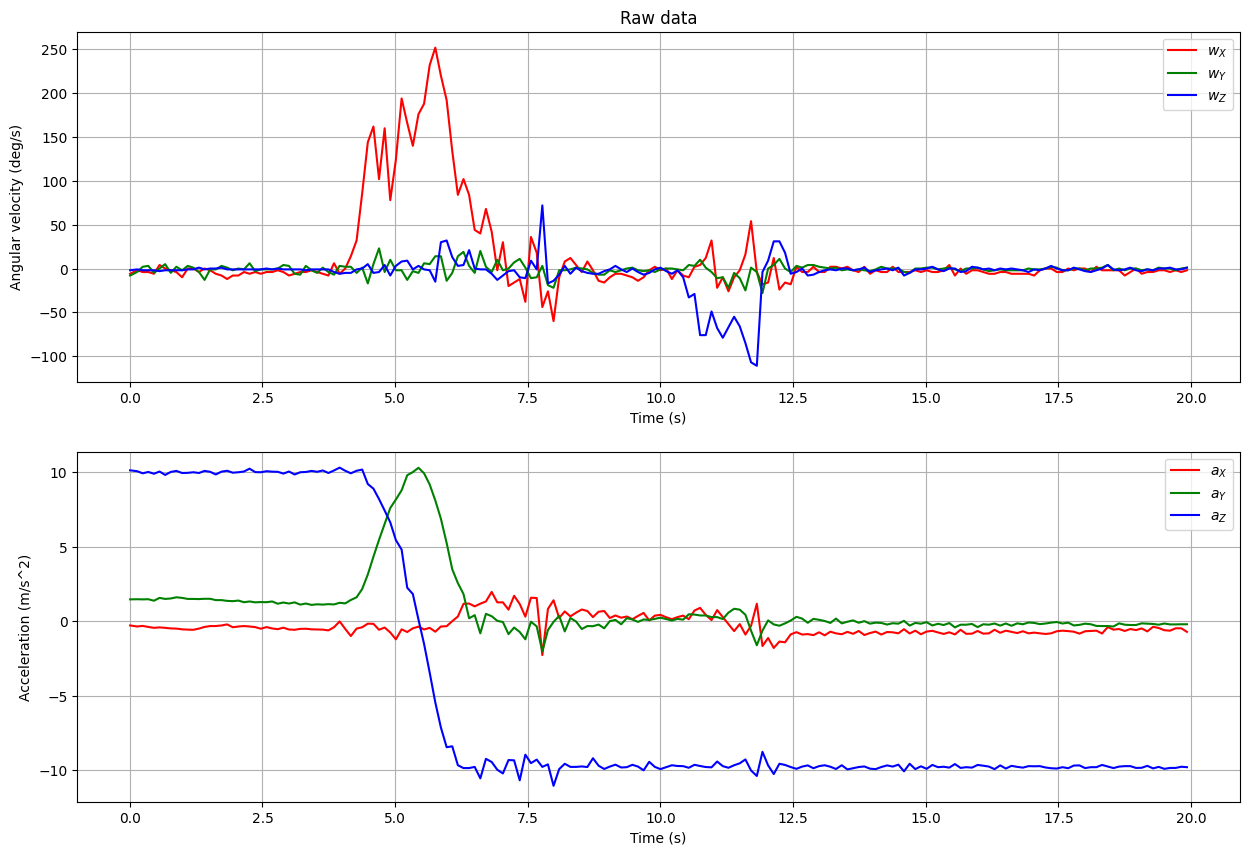

In [ ]:
#accelerometer data(hundredths of meters per second squared)
acceleration = data[:, 1:4] * 0.01
#gyro-rate (degrees per second)
angular_velocity = data[:, 4:7]

plot_data(time, angular_velocity, acceleration, 'Raw data')

### Trajectory

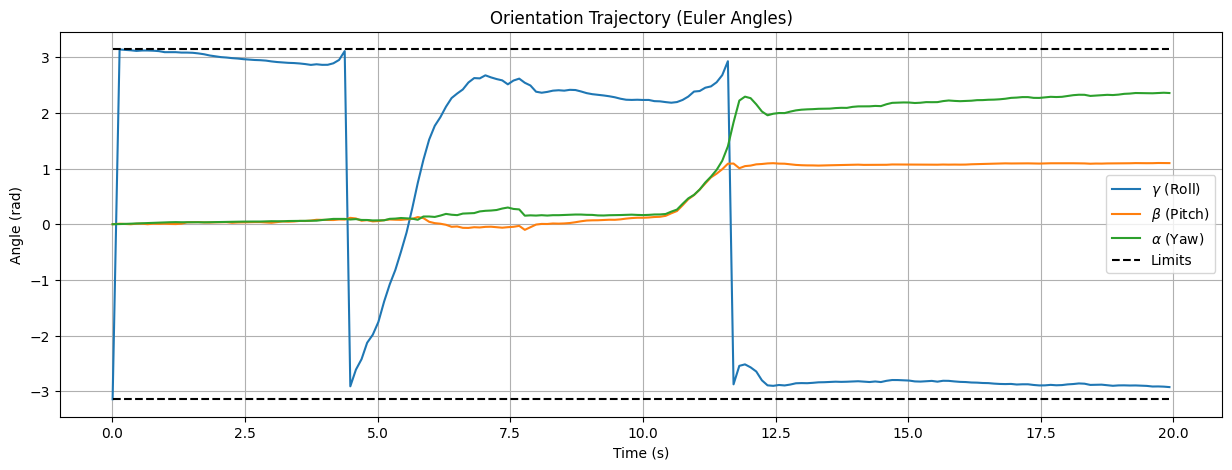

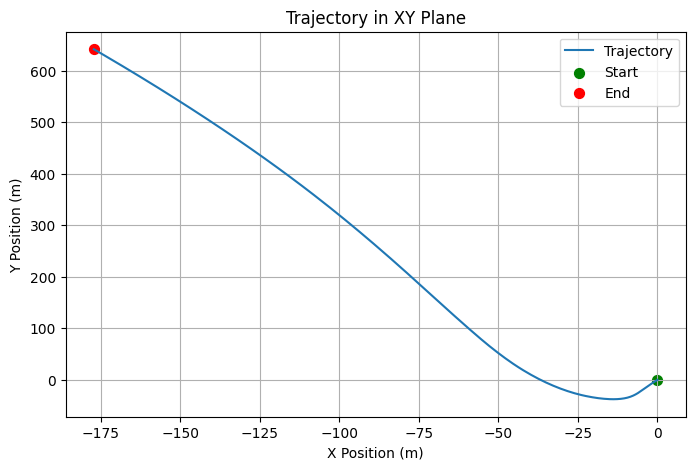

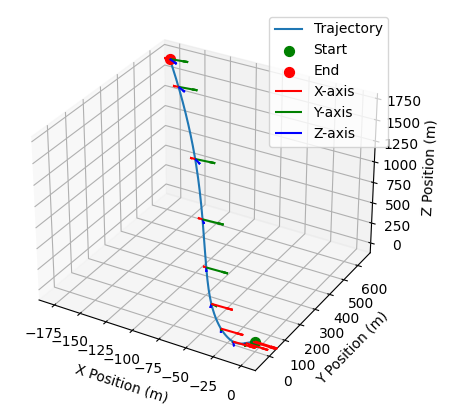

In [5]:
orientation_from_ang_vel(time, np.radians(angular_velocity))
trajectory(time, np.radians(angular_velocity), acceleration, scale=[20,20,20], number_of_points_between_axis=20)

# Task2

### Reduce noise by creating a threshold 

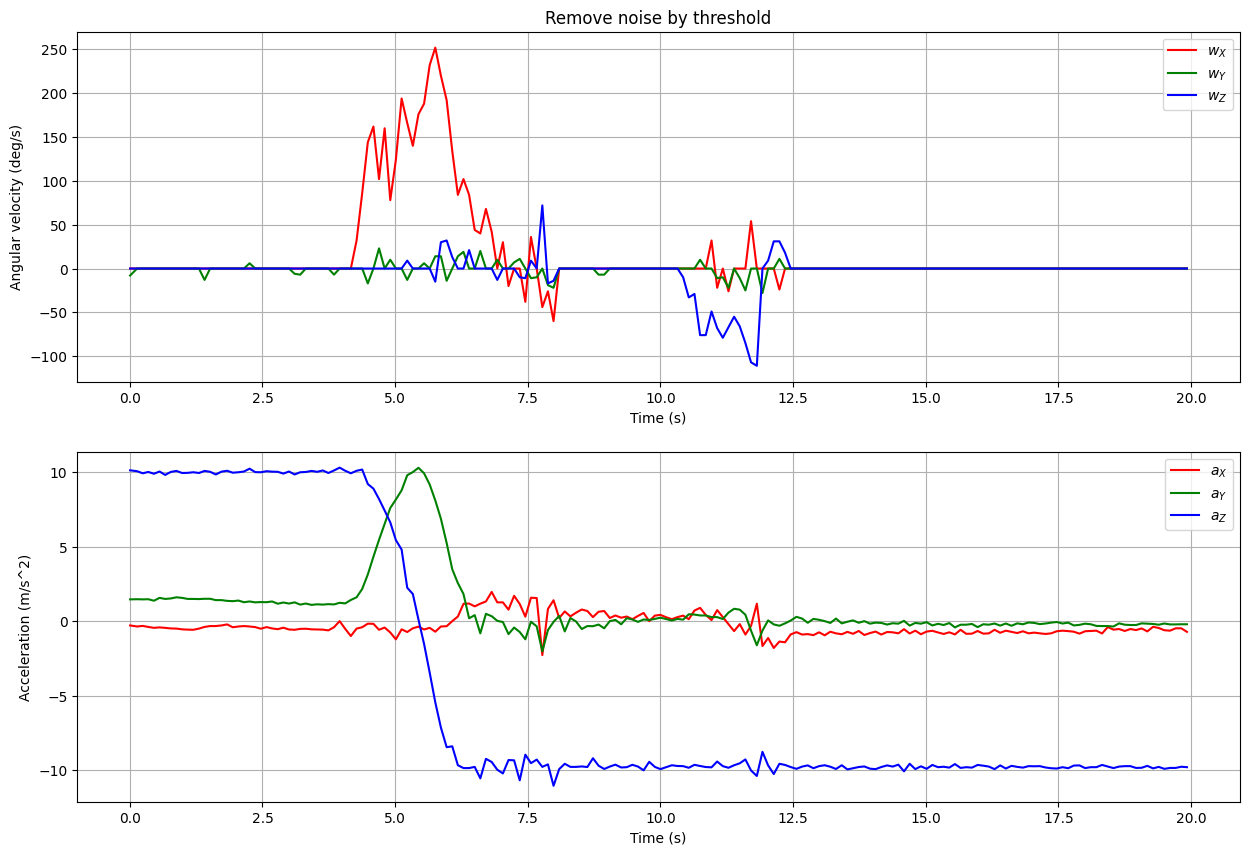

In [6]:
#Measure the variance of the data
static_arm_time = time > 15
var_ang_vel = np.var(angular_velocity[static_arm_time], axis=0)
mask = (angular_velocity > 3 * var_ang_vel) | (angular_velocity < -3 * var_ang_vel)
angular_velocity = np.where(mask, angular_velocity, 0)
var_acceleration = np.var(acceleration[static_arm_time], axis=0)
mask = (acceleration > 3 * var_acceleration) | (acceleration < -3 * var_acceleration)
acceleration = np.where(mask, acceleration,0)

plot_data(time, angular_velocity, acceleration, 'Remove noise by threshold')

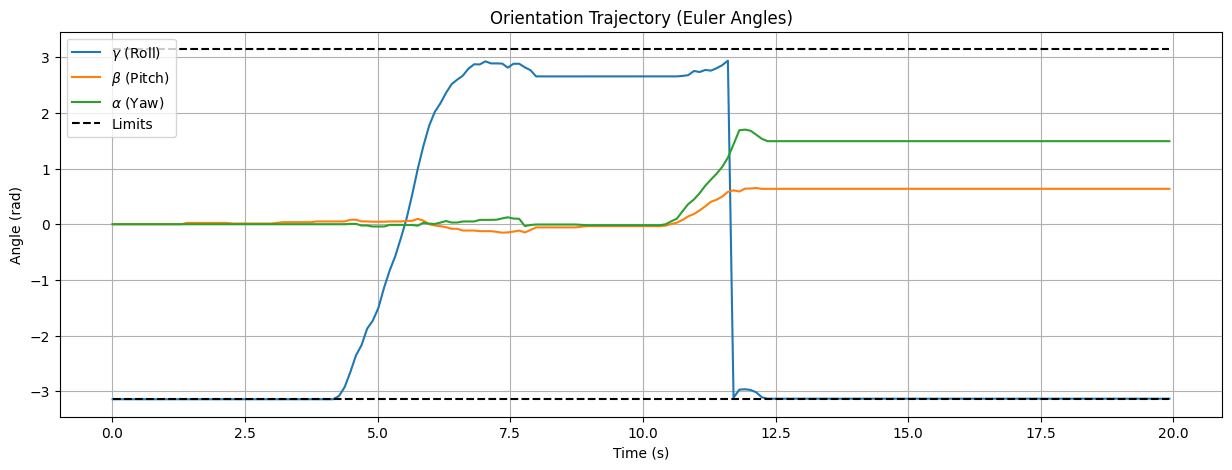

In [7]:
orientation_from_ang_vel(time, np.radians(angular_velocity))
# trajectory(time, np.deg2rad(angular_velocity), acceleration)

# Apply filters

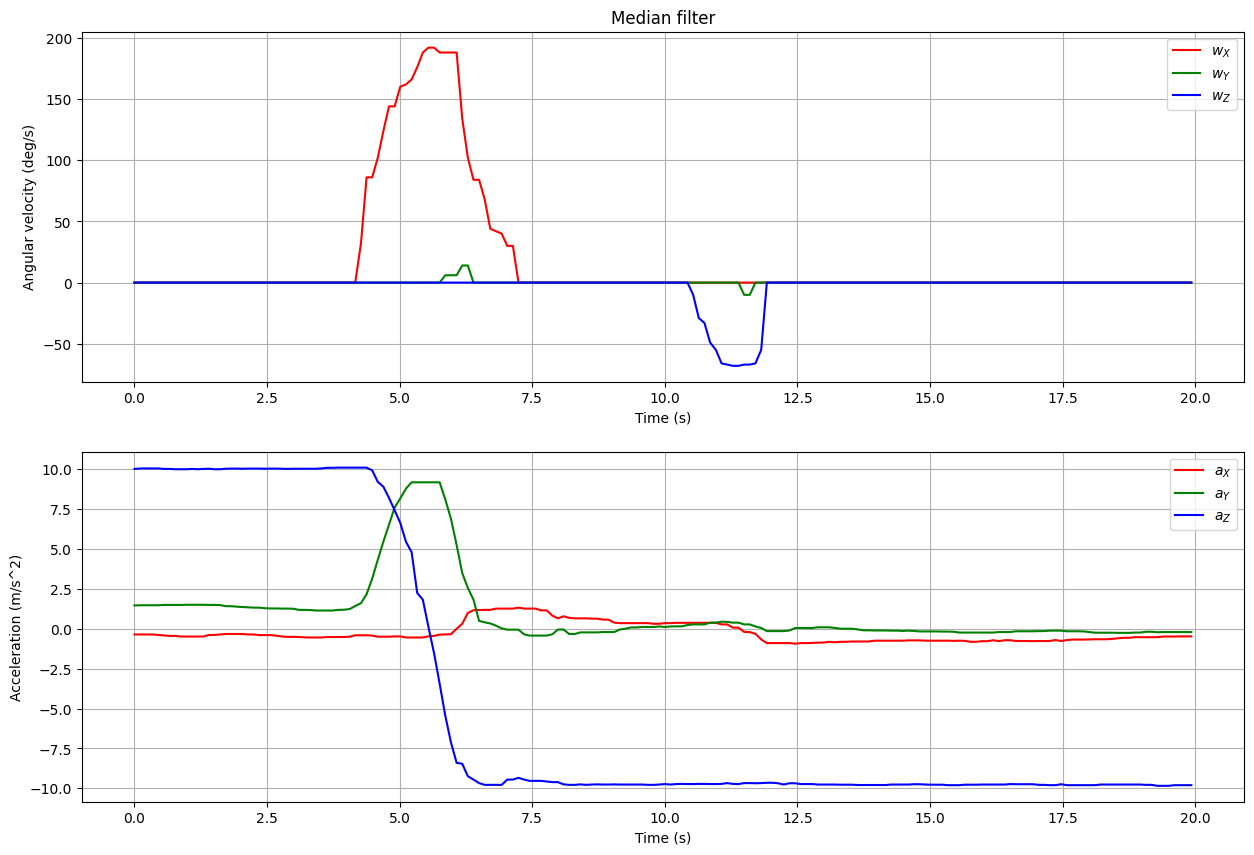

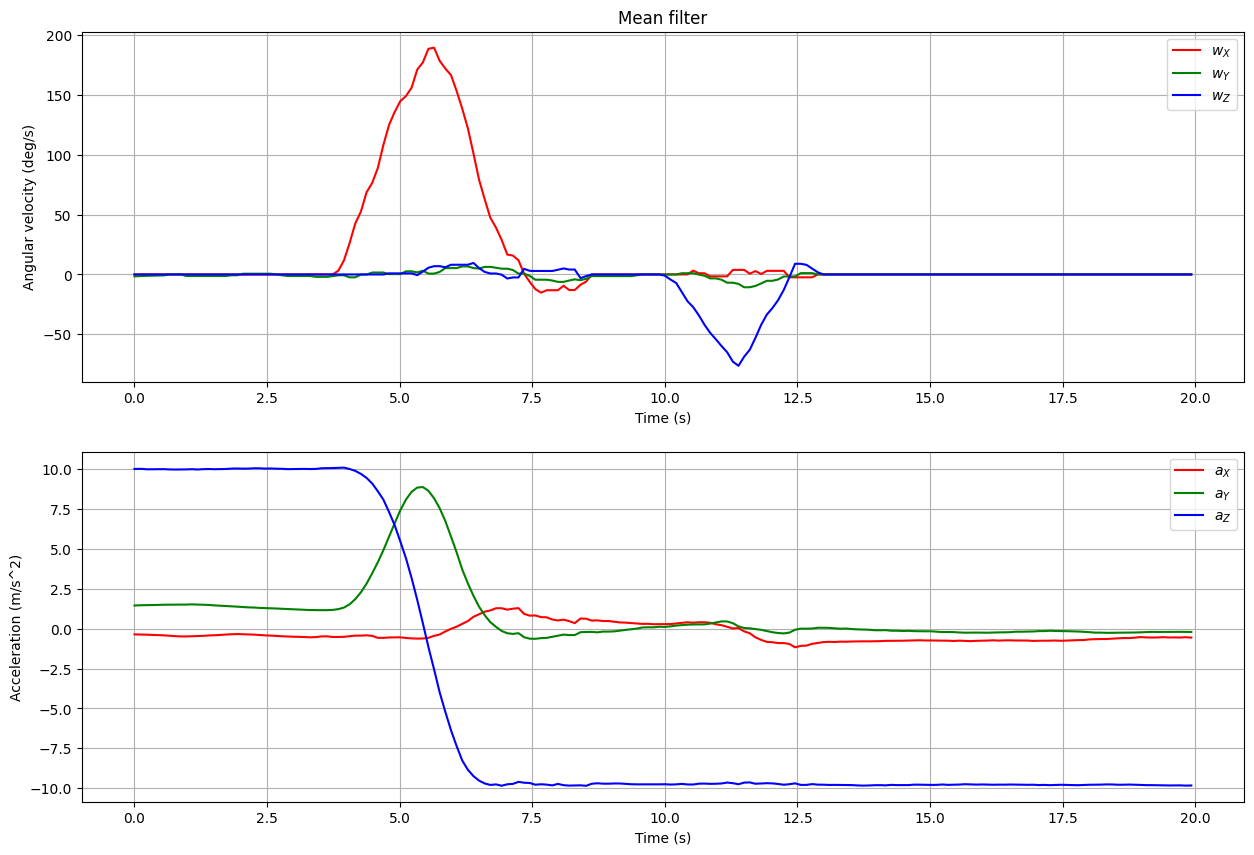

In [8]:
def keep_only_moving(data, axis_moving_data):
    num_points, num_axis = data.shape
    for i in range(num_points):
        data_point = data[i]
        axis_moving = axis_moving_data[i]
        for j in range(num_axis):
            if j != axis_moving:
                data_point[j] = 0
    return data

filtered_ang_vel = median_filter(angular_velocity, size=(10,1))
filtered_acceleration = median_filter(acceleration, size=(10,1))
plot_data(time, filtered_ang_vel, filtered_acceleration, 'Median filter')


#Rolling window mean filter
filtered_mean_ang_vel = np.zeros(angular_velocity.shape)
filtered_mean_acceleration = np.zeros(acceleration.shape)
window_size = 5

for i in range(angular_velocity.shape[0]):
    start = max(0, i - window_size) 
    end = min(angular_velocity.shape[0], i + window_size)
    filtered_mean_ang_vel[i] = np.mean(angular_velocity[start:end], axis=0)
    filtered_mean_acceleration[i] = np.mean(acceleration[start:end], axis=0)
    
plot_data(time, filtered_mean_ang_vel, filtered_mean_acceleration, 'Mean filter')





#### Check rotation

In [9]:
Initial_roll = 0
for i in range(39, 70):
    dt = time[i] - time[i-1]
    Initial_roll += filtered_ang_vel[i, 0] * dt
    # print(f'{Initial_roll:=}, {i=:}, {time[i]=:}, {filtered_ang_vel[i, 0]=:}, {dt=:}')
print(Initial_roll)

356.8993039999999


# Orientation

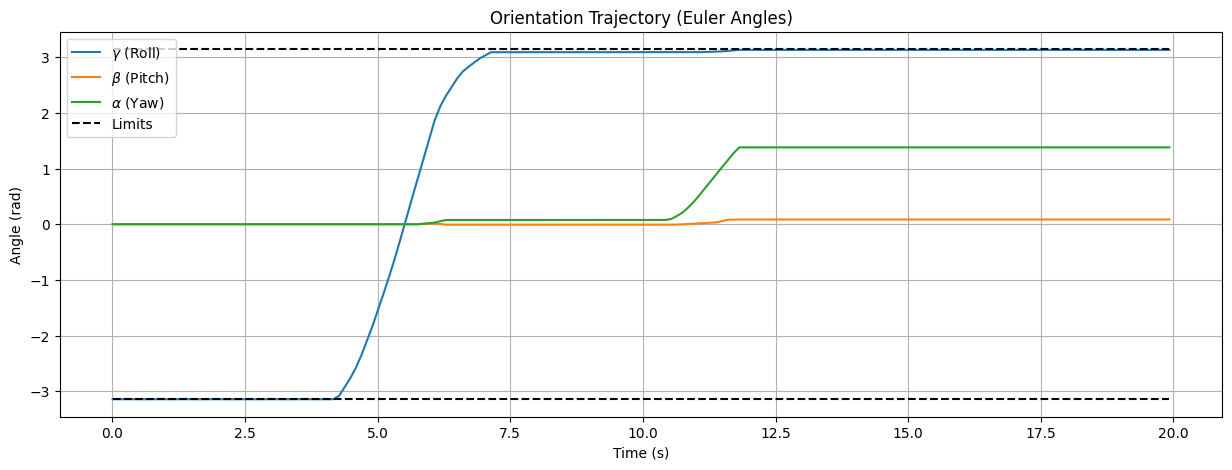

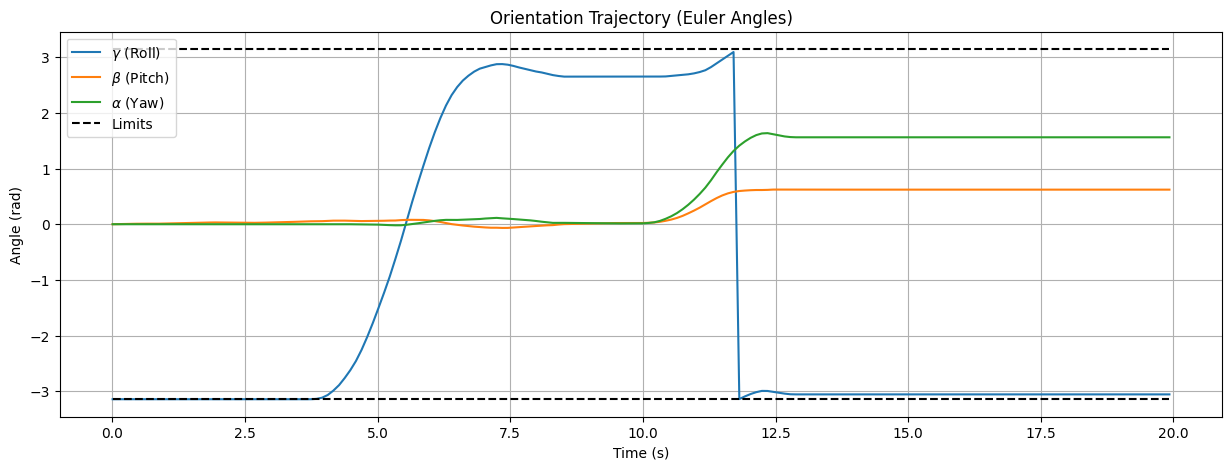

In [10]:
orientation_from_ang_vel(time, np.radians(filtered_ang_vel))
orientation_from_ang_vel(time, np.radians(filtered_mean_ang_vel))

# Trajetória

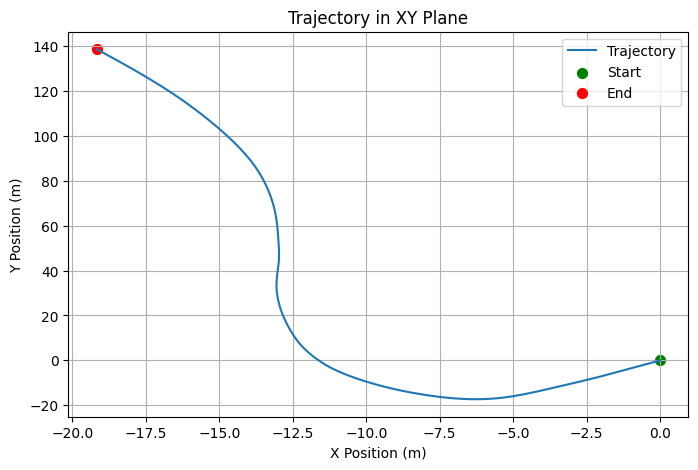

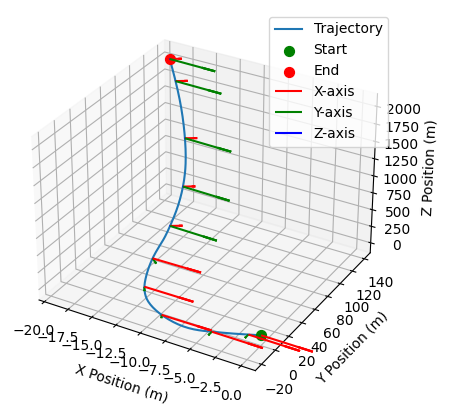

In [11]:
trajectory(time, np.deg2rad(filtered_ang_vel), filtered_acceleration, scale=[5,5,2], number_of_points_between_axis=20)

# Real robot trajectory based only on the orientation

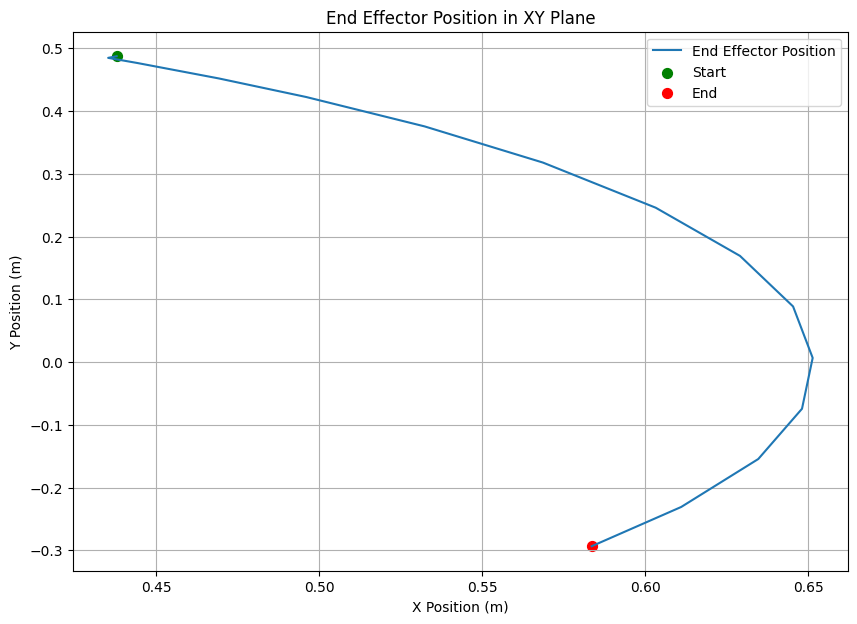

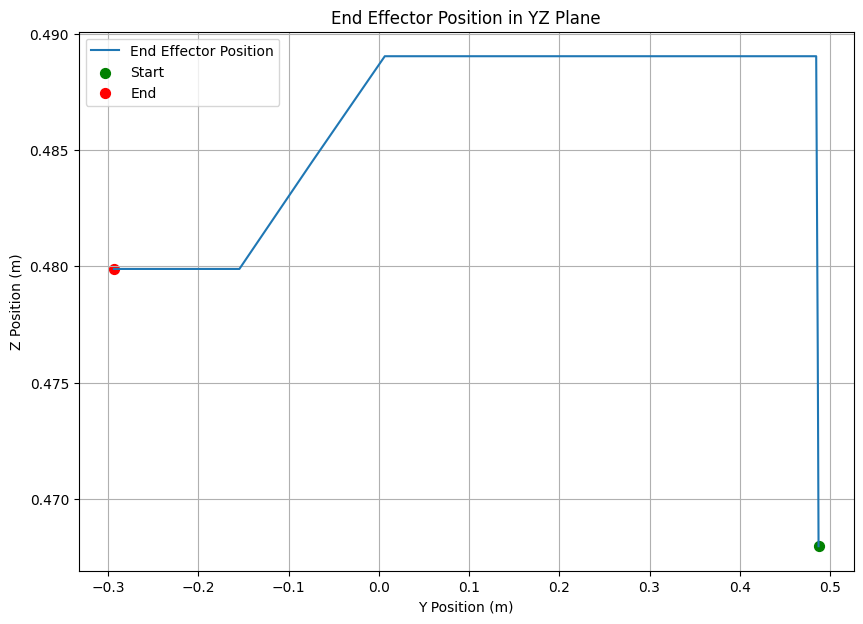

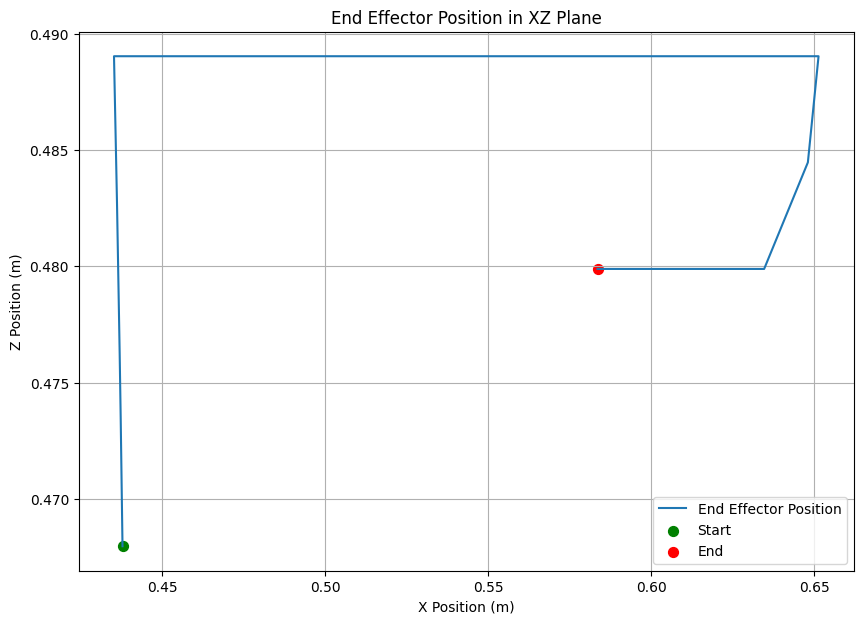

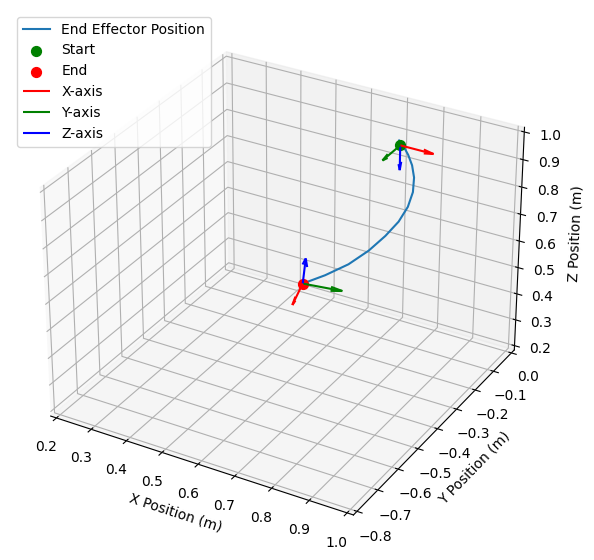

In [12]:
plot_real_robot_orientation(np.load('orientation.npy'))

### Save data 

In [13]:
# np.savetxt('end_point.txt', np.round(end_point  * 10000,0), fmt='%f')
# np.savetxt('roll.txt', np.clip(np.degrees(orientation[:,0])*10, -1799, 6000), fmt='%4f')

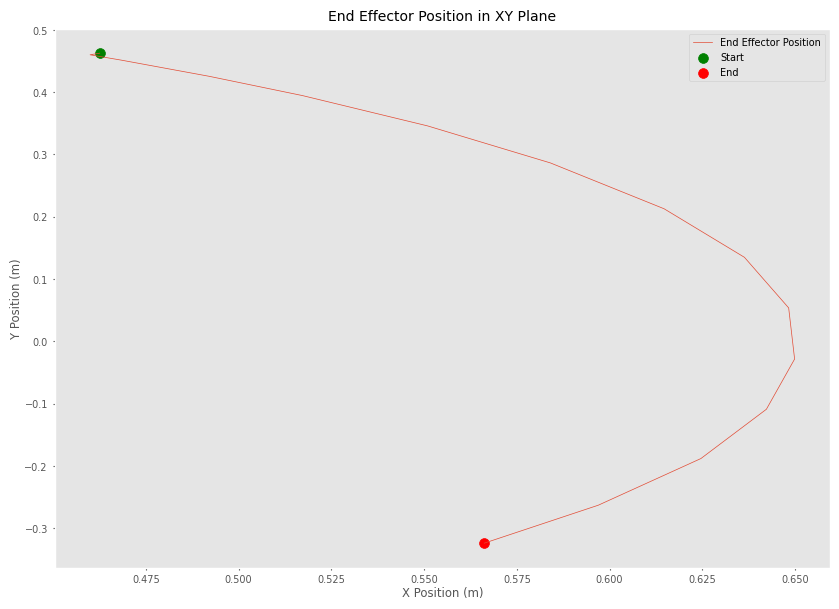

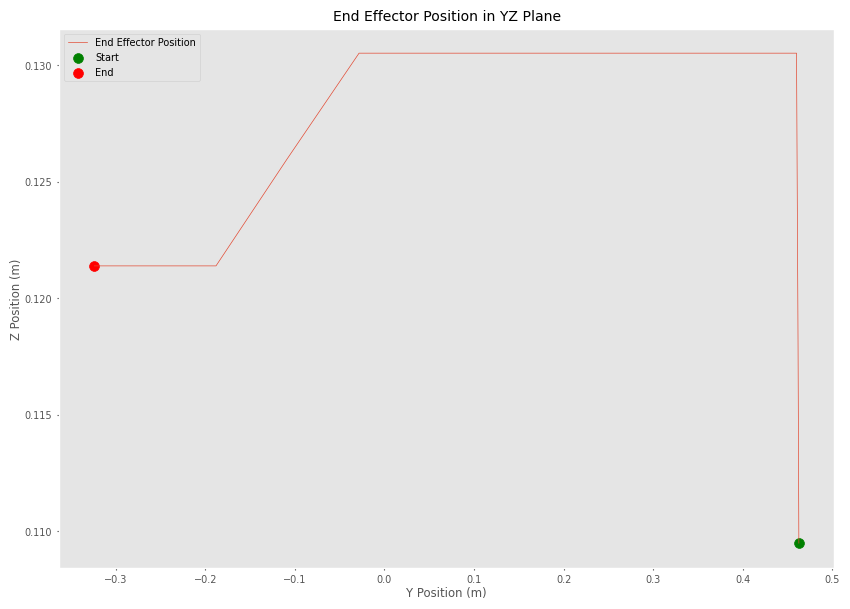

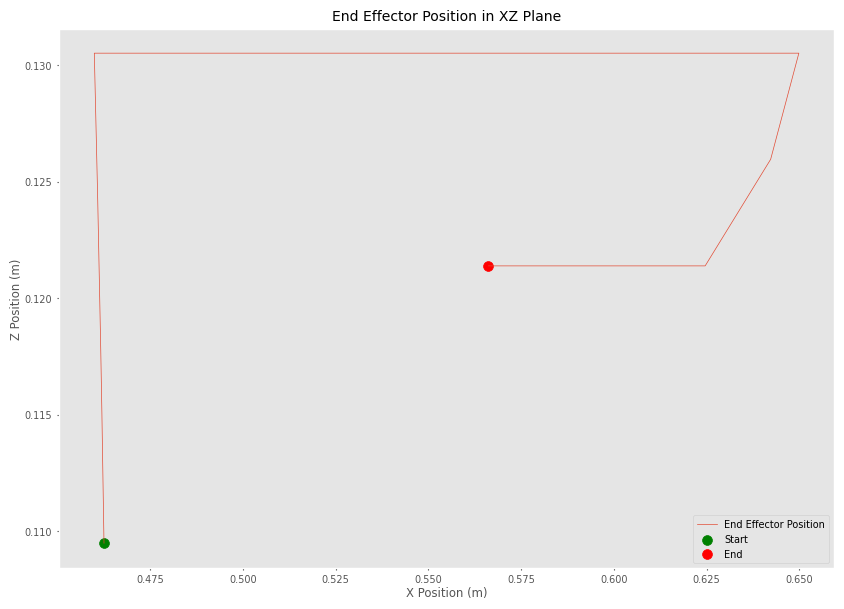

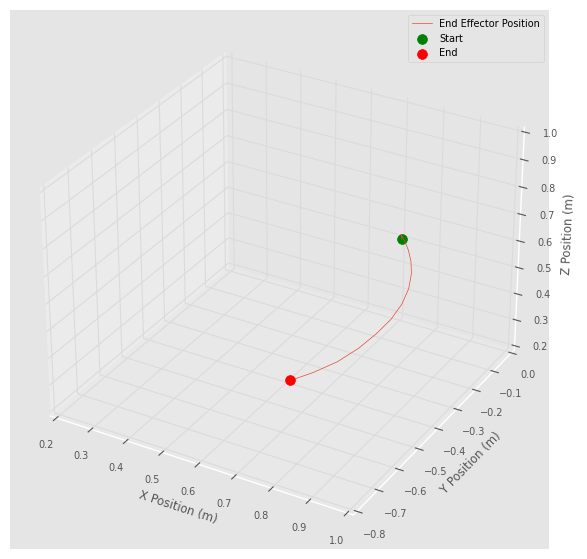

In [14]:
# Now do using the roboticstoolbox library
from roboticstoolbox import DHRobot, RevoluteDH
import numpy as np
from matplotlib import pyplot as plt


robot = DHRobot([
    RevoluteDH(a=0.05, alpha=np.pi/2, offset=np.pi/4),
    RevoluteDH(a=0.3, alpha=0, offset=np.pi/2.4),
    RevoluteDH(a=0.35, alpha=0, offset=-np.pi/1.6),
    RevoluteDH(a=0.251, alpha=-np.pi/2, offset=np.pi/4),
    RevoluteDH(a=0, alpha=0, offset=0)
])
orientation = np.load('orientation.npy')
# robot.plot([0,0,0,0,0])
end_point = []
for i in orientation:
    joint_angles = np.array([i[2], 0, 0, i[1], i[0]])
    points = robot.fkine(joint_angles)
    end_point.append(points.t)
end_point = np.array(end_point)


#XY Plane
plt.figure(figsize=(10, 7))
plt.plot(end_point[:, 0], end_point[:, 1], label="End Effector Position")
plt.scatter(end_point[0, 0], end_point[0, 1], color="green", label="Start", s=50)
plt.scatter(end_point[-1, 0], end_point[-1, 1], color="red", label="End", s=50)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.title('End Effector Position in XY Plane')
plt.grid()
plt.show()

#YZ Plane
plt.figure(figsize=(10, 7))
plt.plot(end_point[:, 1], end_point[:, 2], label="End Effector Position")
plt.scatter(end_point[0, 1], end_point[0, 2], color="green", label="Start", s=50)
plt.scatter(end_point[-1, 1], end_point[-1, 2], color="red", label="End", s=50) 
plt.xlabel('Y Position (m)')
plt.ylabel('Z Position (m)')
plt.legend()
plt.title('End Effector Position in YZ Plane')
plt.grid()
plt.show()

#XZ Plane
plt.figure(figsize=(10, 7))
plt.plot(end_point[:, 0], end_point[:, 2], label="End Effector Position")
plt.scatter(end_point[0, 0], end_point[0, 2], color="green", label="Start", s=50)   
plt.scatter(end_point[-1, 0], end_point[-1, 2], color="red", label="End", s=50)
plt.xlabel('X Position (m)')
plt.ylabel('Z Position (m)')
plt.legend()
plt.title('End Effector Position in XZ Plane')
plt.grid()
plt.show()



# Plot the end effector position in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(end_point[:, 0], end_point[:, 1], end_point[:, 2], label="End Effector Position")
ax.scatter(end_point[0, 0], end_point[0, 1], end_point[0, 2], color="green", label="Start", s=50)
ax.scatter(end_point[-1, 0], end_point[-1, 1], end_point[-1, 2], color="red", label="End", s=50)
# plot_axes(ax, np.array(end_point[0]), orientation[0, 0], orientation[0, 1], orientation[0, 2])
# plot_axes(ax, np.array(end_point[-1]), orientation[-1, 0], orientation[-1, 1], orientation[-1, 2], legend=True)

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')	
ax.set_zlabel('Z Position (m)')
ax.set_xlim([0.2,1])
ax.set_ylim([-0.8, 0])
ax.set_zlim([0.2, 1])
ax.legend()
plt.show()

In [15]:
diff_t = np.diff(time)
len(time)

188

In [16]:
orientation = np.load('orientation.npy')
print(np.pi/2 + orientation[:,2].min())

0.26574466966669785
